# MadMiner particle physics tutorial

# Part 3a: Training a likelihood ratio estimator

Johann Brehmer, Felix Kling, Irina Espejo, and Kyle Cranmer 2018-2019

In part 3a of this tutorial we will finally train a neural network to estimate likelihood ratios. We assume that you have run part 1 and 2a of this tutorial. If, instead of 2a, you have run part 2b, you just have to load a different filename later.

## Preparations

In [17]:
from __future__ import absolute_import, division, print_function, unicode_literals

import logging
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

from madminer.sampling import SampleAugmenter
from madminer import sampling
from madminer.ml import ParameterizedRatioEstimator


In [18]:
# MadMiner output
logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

## 1. Make (unweighted) training and test samples with augmented data

At this point, we have all the information we need from the simulations. But the data is not quite ready to be used for machine learning. The `madminer.sampling` class `SampleAugmenter` will take care of the remaining book-keeping steps before we can train our estimators:

First, it unweights the samples, i.e. for a given parameter vector `theta` (or a distribution `p(theta)`) it picks events `x` such that their distribution follows `p(x|theta)`. The selected samples will all come from the event file we have so far, but their frequency is changed -- some events will appear multiple times, some will disappear.

Second, `SampleAugmenter` calculates all the augmented data ("gold") that is the key to our new inference methods. Depending on the specific technique, these are the joint likelihood ratio and / or the joint score. It saves all these pieces of information for the selected events in a set of numpy files that can easily be used in any machine learning framework.

In [19]:
#sampler = SampleAugmenter('data/lhe_data_shuffled.h5')
sampler = SampleAugmenter('data/delphes_data_shuffled.h5')

13:23 madminer.analysis    INFO    Loading data from data/delphes_data_shuffled.h5
13:23 madminer.analysis    INFO    Found 1 parameters
13:23 madminer.analysis    INFO    Did not find nuisance parameters
13:23 madminer.analysis    INFO    Found 5 benchmarks, of which 5 physical
13:23 madminer.analysis    INFO    Found 35 observables
13:23 madminer.analysis    INFO    Found 3530298 events
13:23 madminer.analysis    INFO      921404 signal events sampled from benchmark no-higgs
13:23 madminer.analysis    INFO      868860 signal events sampled from benchmark sm
13:23 madminer.analysis    INFO      867310 signal events sampled from benchmark 5-higgs
13:23 madminer.analysis    INFO      872724 signal events sampled from benchmark 16-higgs
13:23 madminer.analysis    INFO    Found morphing setup with 5 components
13:23 madminer.analysis    INFO    Did not find nuisance morphing setup


The `SampleAugmenter` class defines five different high-level functions to generate train or test samples:
- `sample_train_plain()`, which only saves observations x, for instance for histograms or ABC;
- `sample_train_local()` for methods like SALLY and SALLINO, which will be demonstrated in the second part of the tutorial;
- `sample_train_density()` for neural density estimation techniques like MAF or SCANDAL;
- `sample_train_ratio()` for techniques like CARL, ROLR, CASCAL, and RASCAL, when only theta0 is parameterized;
- `sample_train_more_ratios()` for the same techniques, but with both theta0 and theta1 parameterized;
- `sample_test()` for the evaluation of any method.

For the arguments `theta`, `theta0`, or `theta1`, you can (and should!) use the helper functions `benchmark()`, `benchmarks()`, `morphing_point()`, `morphing_points()`, and `random_morphing_points()`, all defined in the `madminer.sampling` module.

Here we'll train a likelihood ratio estimator with the ALICES method, so we focus on the `extract_samples_train_ratio()` function. We'll sample the numerator hypothesis in the likelihood ratio with 1000 points drawn from a Gaussian prior, and fix the denominator hypothesis to the SM.

Note the keyword `sample_only_from_closest_benchmark=True`, which makes sure that for each parameter point we only use the events that were originally (in MG) generated from the closest benchmark. This reduces the statistical fluctuations in the outcome quite a bit.

In [5]:
x, theta0, theta1, y, r_xz, t_xz, n_effective = sampler.sample_train_ratio(
    theta0=sampling.random_morphing_points(1000, [('flat', 0., 5.)]),
    theta1=sampling.benchmark('sm'),
    n_samples=10000000,
    folder='./data/samples',
    filename='train_ratio',
    sample_only_from_closest_benchmark=True,
    return_individual_n_effective=True,
)

09:47 madminer.sampling    INFO    Extracting training sample for ratio-based methods. Numerator hypothesis: 1000 random morphing points, drawn from the following priors:
  theta_0 ~ flat from 0.0 to 5.0, denominator hypothesis: sm
09:47 madminer.sampling    INFO    Starting sampling serially
09:47 madminer.sampling    WARNING For this value of theta, 120 / 24671 events have negative weight and will be ignored
09:47 madminer.sampling    WARNING For this value of theta, 129 / 24669 events have negative weight and will be ignored
09:47 madminer.sampling    WARNING For this value of theta, 136 / 24413 events have negative weight and will be ignored
09:47 madminer.sampling    WARNING Skipping warnings about negative weights in the future...
09:48 madminer.sampling    INFO    Sampling from parameter point 50 / 1000
09:49 madminer.sampling    INFO    Sampling from parameter point 100 / 1000
09:50 madminer.sampling    INFO    Sampling from parameter point 150 / 1000
09:51 madminer.sampling   

Let's also make a validation sample:

In [7]:
_ = sampler.sample_train_ratio(
    theta0=sampling.random_morphing_points(100, [('flat', 0., 5.)]),
    theta1=sampling.benchmark('sm'),
    n_samples=100000,
    folder='./data/samples',
    filename='val_ratio',
    sample_only_from_closest_benchmark=True,
    return_individual_n_effective=True,
    partition="validation"
)

10:33 madminer.sampling    INFO    Extracting training sample for ratio-based methods. Numerator hypothesis: 100 random morphing points, drawn from the following priors:
  theta_0 ~ flat from 0.0 to 5.0, denominator hypothesis: sm
10:33 madminer.sampling    INFO    Starting sampling serially
10:33 madminer.sampling    WARNING For this value of theta, 227 / 24744 events have negative weight and will be ignored
10:33 madminer.sampling    WARNING For this value of theta, 201 / 24756 events have negative weight and will be ignored
10:33 madminer.sampling    WARNING For this value of theta, 206 / 24708 events have negative weight and will be ignored
10:33 madminer.sampling    WARNING Skipping warnings about negative weights in the future...
10:33 madminer.sampling    INFO    Sampling from parameter point 5 / 100
10:33 madminer.sampling    INFO    Sampling from parameter point 10 / 100
10:33 madminer.sampling    INFO    Sampling from parameter point 15 / 100
10:33 madminer.sampling    INFO  

For the evaluation we'll need a few test samples:

In [8]:
_ = sampler.sample_test(
    theta=sampling.morphing_point([0.]),
    n_samples=10000,
    folder='./data/samples',
    filename='test00'
)

_ = sampler.sample_test(
    theta=sampling.morphing_point([0.8]),
    n_samples=10000,
    folder='./data/samples',
    filename='test08'
)

_ = sampler.sample_test(
    theta=sampling.morphing_point([1.0]),
    n_samples=10000,
    folder='./data/samples',
    filename='test10'
)

_ = sampler.sample_test(
    theta=sampling.morphing_point([1.2]),
    n_samples=10000,
    folder='./data/samples',
    filename='test12'
)

_ = sampler.sample_test(
    theta=sampling.morphing_point([2.]),
    n_samples=10000,
    folder='./data/samples',
    filename='test20'
)

_ = sampler.sample_test(
    theta=sampling.morphing_point([4.]),
    n_samples=10000,
    folder='./data/samples',
    filename='test40'
)

10:35 madminer.sampling    INFO    Extracting evaluation sample. Sampling according to [0.]
10:35 madminer.sampling    INFO    Starting sampling serially
10:35 madminer.sampling    INFO    Sampling from parameter point 1 / 1
10:35 madminer.sampling    INFO    Effective number of samples: mean 176420.55844397115, with individual thetas ranging from 176420.5584439712 to 176420.5584439712
10:35 madminer.sampling    INFO    Extracting evaluation sample. Sampling according to [0.8]
10:35 madminer.sampling    INFO    Starting sampling serially
10:35 madminer.sampling    INFO    Sampling from parameter point 1 / 1
10:35 madminer.sampling    INFO    Effective number of samples: mean 5736.137199030765, with individual thetas ranging from 5736.137199030763 to 5736.137199030763
10:35 madminer.sampling    INFO    Extracting evaluation sample. Sampling according to [1.]
10:35 madminer.sampling    INFO    Starting sampling serially
10:35 madminer.sampling    INFO    Sampling from parameter point 1 /

You might notice the information about the "effective number of samples" in the output. This is defined as `1 / max_events(weights)`; the smaller it is, the bigger the statistical fluctuations from too large weights. Let's plot this over the parameter space:

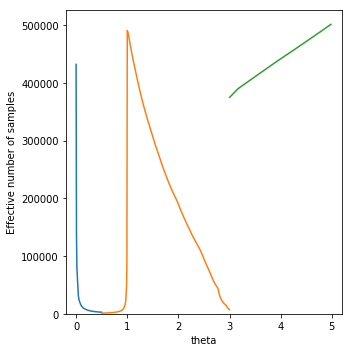

In [23]:
cut = (y.flatten()==0)

x_ = theta0[cut][:,0]
y_ = n_effective[cut]

order = np.argsort(x_)
y_ = y_[order]
x_ = x_[order]

fig = plt.figure(figsize=(5,5))

plt.plot(x_[x_<0.5], y_[x_<0.5], lw=1.5)
plt.plot(x_[(x_>0.5)*(x_<3)], y_[(x_>0.5)*(x_<3)], lw=1.5)
plt.plot(x_[x_>3.], y_[x_>3.], lw=1.5)

plt.xlabel("theta")
plt.ylabel('Effective number of samples')
plt.xlim(-0.2,5.2)
plt.ylim(0.,None)
#plt.yscale("log")

plt.tight_layout()
plt.savefig("effective_samplesize.pdf")


## 2. Plot cross section over parameter space

This is not strictly necessary, but we can also plot the cross section as a function of parameter space:

In [31]:
thetas_benchmarks, xsecs_benchmarks, xsec_errors_benchmarks = sampler.cross_sections(
    theta=sampling.benchmarks(list(sampler.benchmarks.keys()))
)

thetas_morphing, xsecs_morphing, xsec_errors_morphing = sampler.cross_sections(
    theta=sampling.random_morphing_points(100, [('flat', 0., 20.)])
)

13:42 madminer.sampling    INFO    Starting cross-section calculation
13:42 madminer.sampling    INFO    Starting cross-section calculation


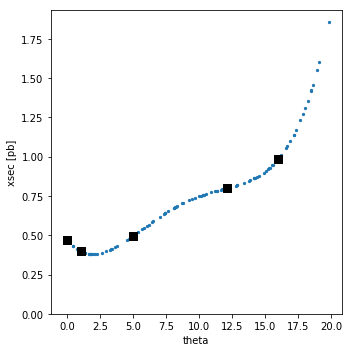

In [32]:
fig = plt.figure(figsize=(5,5))

sc = plt.scatter(thetas_morphing[:,0], xsecs_morphing, s=5., marker='o')

plt.scatter(thetas_benchmarks[:,0], xsecs_benchmarks, s=50., marker='s', c="black")

plt.xlabel("theta")
plt.ylabel('xsec [pb]')

plt.ylim(0., None)
plt.tight_layout()
plt.savefig("xsec.pdf")


What  you see here is a morphing algorithm in action. We only asked MadGraph to calculate event weights (differential cross sections, or basically squared matrix elements) at six fixed parameter points (shown here as squares with black edges). But with our knowledge about the structure of the process we can interpolate any observable to any parameter point without loss (except that statistical uncertainties might increase)!

## 3. Train likelihood ratio estimator

It's now time to build the neural network that estimates the likelihood ratio. The central object for this is the `madminer.ml.ParameterizedRatioEstimator` class. It defines functions that train, save, load, and evaluate the estimators.

In the initialization, the keywords `n_hidden` and `activation` define the architecture of the (fully connected) neural network:

In [14]:
estimator = ParameterizedRatioEstimator(
    n_hidden=(100,100,),
    activation="tanh",
    dropout_prob=0.2,
)

To train this model we will minimize the ALICES loss function described in ["Likelihood-free inference with an improved cross-entropy estimator"](https://arxiv.org/abs/1808.00973). Many alternatives, including RASCAL, are described in ["Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00013) and ["A Guide to Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00020). There is also SCANDAL introduced in ["Mining gold from implicit models to improve likelihood-free inference"](https://arxiv.org/abs/1805.12244).

In [15]:
estimator.train(
    method='alices',
    theta='data/samples/theta0_train_ratio.npy',
    x='data/samples/x_train_ratio.npy',
    y='data/samples/y_train_ratio.npy',
    r_xz='data/samples/r_xz_train_ratio.npy',
    t_xz='data/samples/t_xz_train_ratio.npy',
    theta_val='data/samples/theta0_val_ratio.npy',
    x_val='data/samples/x_val_ratio.npy',
    y_val='data/samples/y_val_ratio.npy',
    r_xz_val='data/samples/r_xz_val_ratio.npy',
    t_xz_val='data/samples/t_xz_val_ratio.npy',
    alpha=1.,
    n_epochs=5,
    batch_size=512,
    n_workers=4,
)

estimator.save('models/alices')

11:42 madminer.ml          INFO    Starting training
11:42 madminer.ml          INFO      Method:                 alices
11:42 madminer.ml          INFO      alpha:                  1.0
11:42 madminer.ml          INFO      Batch size:             512
11:42 madminer.ml          INFO      Optimizer:              amsgrad
11:42 madminer.ml          INFO      Epochs:                 5
11:42 madminer.ml          INFO      Learning rate:          0.001 initially, decaying to 0.0001
11:42 madminer.ml          INFO      Validation split:       0.25
11:42 madminer.ml          INFO      Early stopping:         True
11:42 madminer.ml          INFO      Scale inputs:           True
11:42 madminer.ml          INFO      Scale parameters:       True
11:42 madminer.ml          INFO      Shuffle labels          False
11:42 madminer.ml          INFO      Samples:                all
11:42 madminer.ml          INFO    Loading training data
11:42 madminer.utils.vario INFO      Loading data/samples/theta0_tr

KeyboardInterrupt: 

## 4. Evaluate likelihood ratio estimator

`estimator.evaluate_log_likelihood_ratio(theta,x)` estimated the log likelihood ratio and the score for all combination between the given phase-space points `x` and parameters `theta`. That is, if given 100 events `x` and a grid of 25 `theta` points, it will return 25\*100 estimates for the log likelihood ratio and 25\*100 estimates for the score, both indexed by `[i_theta,i_x]`.

In [5]:
theta_each = np.linspace(-20.,20.,21)
theta0, theta1 = np.meshgrid(theta_each, theta_each)
theta_grid = np.vstack((theta0.flatten(), theta1.flatten())).T
np.save('data/samples/theta_grid.npy', theta_grid)

theta_denom = np.array([[0.,0.]])
np.save('data/samples/theta_ref.npy', theta_denom)


In [6]:
estimator.load('models/alices')

log_r_hat, _ = estimator.evaluate_log_likelihood_ratio(
    theta='data/samples/theta_grid.npy',
    x='data/samples/x_test.npy',
    evaluate_score=False
)

11:48 madminer.ml          INFO    Loading model from models/alices
11:48 madminer.ml          WARNING Parameter scaling information not found in models/alices
11:48 madminer.ml          INFO    Loading evaluation data
11:48 madminer.utils.vario INFO      Loading data/samples/x_test.npy into RAM
11:48 madminer.utils.vario INFO      Loading data/samples/theta_grid.npy into RAM
11:48 madminer.ml          INFO    Starting ratio evaluation for 441000 x-theta combinations
11:48 madminer.ml          INFO    Evaluation done


Let's look at the result:

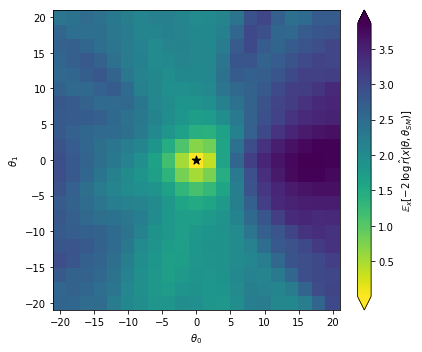

In [7]:
bin_size = theta_each[1] - theta_each[0]
edges = np.linspace(theta_each[0] - bin_size/2, theta_each[-1] + bin_size/2, len(theta_each)+1)

fig = plt.figure(figsize=(6,5))
ax = plt.gca()

expected_llr = np.mean(log_r_hat,axis=1)
best_fit = theta_grid[np.argmin(-2.*expected_llr)]

cmin, cmax = np.min(-2*expected_llr), np.max(-2*expected_llr)
    
pcm = ax.pcolormesh(edges, edges, -2. * expected_llr.reshape((21,21)),
                    norm=matplotlib.colors.Normalize(vmin=cmin, vmax=cmax),
                    cmap='viridis_r')
cbar = fig.colorbar(pcm, ax=ax, extend='both')

plt.scatter(best_fit[0], best_fit[1], s=80., color='black', marker='*')

plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
cbar.set_label(r'$\mathbb{E}_x [ -2\, \log \,\hat{r}(x | \theta, \theta_{SM}) ]$')

plt.tight_layout()
plt.show()


Note that in this tutorial our sample size was very small, and the network might not really have a chance to converge to the correct likelihood ratio function. So don't worry if you find a minimum that is not at the right point (the SM, i.e. the origin in this plot). Feel free to dial up the event numbers in the run card as well as the training samples and see what happens then!